<h2 align="center">Implementation of the Logistic Regression Classification Algorithm</h3>
<h4 align="center">Machine Learning & Data Mining - Assignment 3</h3>
<h4 align="center">Stephen Dooley - 12502947 - 23/11/15</h3> 

### Import csv file containing owl data

In [60]:
import pandas as pd
# import csv to visualise data
df = pd.read_csv('../data/owls-csv.csv')

# get the user input
number_of_classes = int(input('How many types of owls are there?\n'));

How many types of owls are there?
3


### Plot the data

The data is divided by each of the following types:
* Long Eared Owl
* Snowy Owl
* Barn Owl 

Populating the interactive namespace from numpy and matplotlib
Enter preferred max value for y-axis:
9


/Users/stephen/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


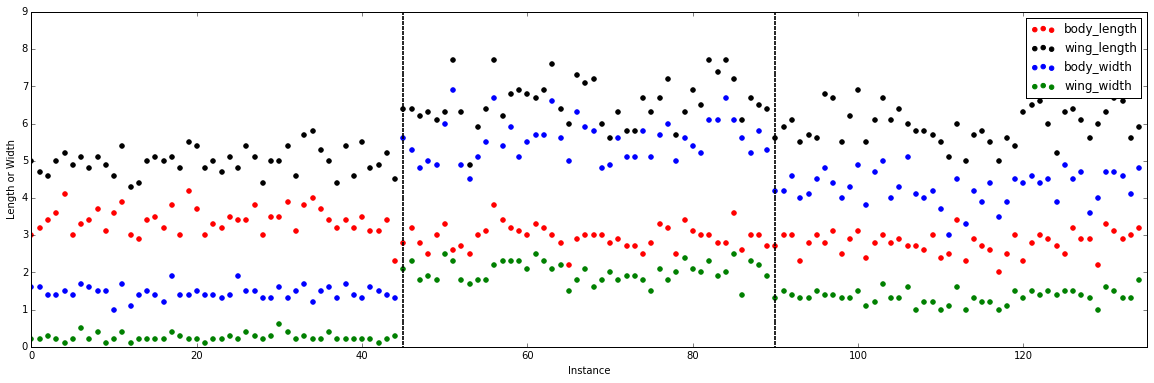

In [62]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%pylab inline

# get user input 
y_max = int(input('Enter preferred max value for y-axis:\n'));

# generify plot variable to work for different number of attributes
number_of_instances = len(df.type);
instances_per_class = number_of_instances/number_of_classes;

# initliase the dividers for the graph
# helps to build a visualisation of the classes
x_divider_one = [instances_per_class]*number_of_instances; 
x_divider_two = [instances_per_class*2]*number_of_instances;
y_divider = np.arange(0, y_max, y_max/number_of_instances);

# setup figure
fig = plt.figure(figsize=(20, 6));
ax1 = fig.add_subplot(111);
# plot the data 
cm_bright = ListedColormap(['#FF0000', '#0000FF']);

''' scatter(x, y, marker size, color, marker color style, label) '''
ax1.scatter(np.arange(number_of_instances), df.body_length, color='red', cmap=cm_bright, label='body_length');
ax1.scatter(np.arange(number_of_instances), df.wing_length, color='black', cmap=cm_bright, label='wing_length'); 
ax1.scatter(np.arange(number_of_instances), df.body_width, color='blue', cmap=cm_bright, label='body_width'); 
ax1.scatter(np.arange(number_of_instances), df.wing_width, color='green', cmap=cm_bright, label='wing_width');
ax1.scatter(x_divider_one, y_divider, s=1, color='black', cmap=cm_bright);
ax1.scatter(x_divider_two, y_divider, s=1, color='black', cmap=cm_bright);
ax1.set_xlim(0, number_of_instances)
ax1.set_ylim(0, y_max);
ax1.set_xlabel('Instance');
ax1.set_ylabel('Length or Width');
ax1.legend(loc='upper right');

As seen from the plot above, the attributes of the Long Eared Owl (left), are easily differentiated from the those of the Snowy Owl (middle) and Barn Owl (left). It is observed that the body length for the Long Eared owl lies within the same range as the body length of other types of owl. Although all three types of owl share similar body length it appears as though error in the algorithm may arrise when trying to distinguish between the Snowy Owl and Barn Owl. These two types of owl contain similar ranges of values for body length, wing length, body width and wind width.

The logistic regression algorithm was implemented in the source code below. In logistic regression, the predictions of the model are constrained to the range [0,1]. This is to alow the value to be interpretted as an estimation of the probability. The estimated probability is used to predict which type of owl the instance in question belongs to. By using the logit function (inverse of logistic function), it is possible to translate the predictions from the range [−∞,∞] to [0,1]. It translates a *K*-dimensional vector $x$ of real values to a *K*-dimensional vector $\sigma(\mathbf{x})$ of real values in the range (0, 1). They represent the probablilties and the sum of all attributes of the vector $\sigma(\mathbf{x})$ add up to 1. The logistic function (or softmax function for multiclass tasks) of a number x between 0 and 1 is given by:

$$ \sigma(\mathbf{x})_j = \frac{1}{1 + e^{-x}} = \frac{e^{xk}}{\sum_{k}^{K} e^{xk}} $$

The graph of this function can be seen below:

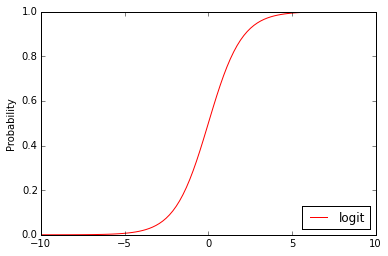

In [116]:
x = np.linspace(-10, 10, 100)
y = 1.0 / (1.0 + np.exp(-x))
ax2 = plt.subplot(111)
ax2.plot(x, y, 'r-', label='logit')
ax2.set_ylabel('Probability');
ax2.legend(loc='lower right')

## Source code for Logistic Regression
The logistic function is found in the *softmax( )* function below. The function in its original form is evaluated as:

$$ \frac{e^{xk}}{\sum_{k}^{K} e^{xk}} $$

In [125]:
import sys
import numpy
import csv
from decimal import Decimal
import random as rnd
numpy.seterr(all='ignore')

##################################### UTILITY FUNCTIONS ######################################

# file_reader 
#
# Reads in the data file from local storage
#
# @params {String} file_name - location of file on disk
def file_reader(file_name):
    inputs = [];
    i = 0;
    with open(file_name, 'r') as csvfile:
        file = csv.reader(csvfile, delimiter='\n')
        for row in file:
            split_row = row[0].split(',')
            floats = [float(x) for x in split_row]
            inputs.append(floats)
    # return the input array
    return inputs;

# normalise_data
#
# Normalises the data inputs for the model to erradicate the effect of outliers.
# The data is normalised with 0-1 normalisation by dividing the data for each 
# instance by the max value for that instance.
#
# @params {List} data - list of lists, containing the data about each instance
def normalise_data(data):
    # number of intances in dataset
    numberOfInstances = len(data)

    for i in range(0, numberOfInstances):
        # get values needed for normalisation
        # for 0-1 normalisation
        minValue = min(data[i])
        maxValue = max(data[i])

        #normalize each element of the lists
        x = 0
        while x < len(data[i]):
            # 0-1 normalisation
            data[i][x] = data[i][x]/maxValue
            x = x + 1
    return data;

# percentage_split_data
#
# Split the data by a given percentage based on whether you are training 
# or testing the model
#
# @params {List} data - list of lists, each row representing an instance
def percentage_split_data(data, percentage):
    # get the number of samples needed to make up specified percentage
    number_of_samples = int( len(data)*(percentage/100) )
    # list of indices to sample the data with
    indices = rnd.sample(range(len(data)), number_of_samples)
    split_list = []
    for index, row in enumerate(data):
        # if the index is found in the list of random indices, take the instance
        if index in indices:
            split_list.append(row)
            
    # convert the list back to an array
    output_list = np.asarray(split_list)
    # return the sampled data
    return output_list
    
# softmax
#
# Logisitc Regression function used to restrict the outputs to a 
# range of 0 --> 1. The outputs can then be interpretted as a 
# probability or odds.
#
# @params {Object} x - data to train/test on 
def softmax(x):
    # e = numpy.exp(x - numpy.max(x))  # prevent overflow
    e = numpy.exp(x)
    # when there is only 1 instance to test
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    # testing multiple instances
    else:  
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # number of dimensions = 4
#############################################################################################



##################################### REGRESSION FUNCTION ######################################

# Logistic Regression
#
# Inner class to build the Logistic Regression model.
# It trains the data on 66% and tests on 33%.
#
# object - contains the parameters that define the regression 
class LogisticRegression(object):
    def __init__(self, input, type_of_owl, n_in, n_out):
        self.x = input                       # input values of owls
        self.y = type_of_owl                 # output values 
        self.W = numpy.zeros((n_in, n_out))  # initialize W 0
        self.b = numpy.zeros(n_out)          # initialize bias 0
        self.params = [self.W, self.b]

    def train(self, lr=0.01, input=None, L2_reg=0.00):
        if input is not None:
            self.x = input

        prob_y_given_x = softmax(numpy.dot(self.x, self.W) + self.b)
        diff_y = self.y - prob_y_given_x
        
        self.W += lr * numpy.dot(self.x.T, diff_y) - lr * L2_reg * self.W
        self.b += lr * numpy.mean(diff_y, axis=0)
        
        # cost = self.negative_log_likelihood()
        # return cost

    def negative_log_likelihood(self):
        sigmoid_activation = softmax(numpy.dot(self.x, self.W) + self.b)

        cross_entropy = - numpy.mean(
            numpy.sum(self.y * numpy.log(sigmoid_activation) +
            (1 - self.y) * numpy.log(1 - sigmoid_activation),
                      axis=1))

        return cross_entropy


    def predict(self, x):
        return softmax(numpy.dot(x, self.W) + self.b)
#############################################################################################



####################################### TEST FUNCTION ########################################
def test_algorithm(learning_rate=0.01, n_interations=500):
    training_percentage = 66
    testing_percentage = 100 - training_percentage
    
    # training data
    input_data = numpy.array( file_reader('../data/inputs') );
    # get percentage of dataset for training - Example: percentage_split_data(data, 66)
    training_data_x = percentage_split_data(input_data, 66)
    # normalize the data
    x = normalise_data(training_data_x)
    
    # types of owl
    existing_clssification = numpy.array( file_reader('../data/outputs') );
    # outputs: (data, percentage split)
    training_data_y = percentage_split_data(existing_clssification, training_percentage)
    y = training_data_y;

    # build LogisticRegression model
    LogisticRegressionModel = LogisticRegression(input=x, type_of_owl=y, n_in=(len(df.columns)-1), n_out=number_of_classes)

    # train
    for iteration in range(n_interations):
        LogisticRegressionModel.train(lr=learning_rate)
        # cost = LogisticRegressionModel.negative_log_likelihood()
        # print(sys.stderr, 'Training epoch %d, cost is ' % iteration, cost)
        learning_rate *= 0.95


    # test
    testing_data_x = percentage_split_data(input_data, testing_percentage)
    # normalize the data
    x = normalise_data(testing_data_x)
    print(sys.stderr, LogisticRegressionModel.predict(x[0]))
#############################################################################################



####################################### MAIN PROGRAM ########################################
if __name__ == "__main__":
    test_algorithm()
#############################################################################################


<ipykernel.iostream.OutStream object at 0x103de1a58> [ 0.52539463  0.21100254  0.26360283]


In [118]:
print(distData)



ParallelCollectionRDD[4] at parallelize at PythonRDD.scala:423
